In [179]:
#importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.regularizers import l2
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout,SimpleRNN,Bidirectional,LSTM,BatchNormalization,Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score, f1_score,confusion_matrix

In [181]:
# loding dataset
df=pd.read_csv("updated_dataset.csv")

<h3>EDA(Exploratory Data Analysis)</h3>

In [187]:
df.shape

(1670, 3)

In [189]:
df.duplicated().sum()

0

In [191]:
df.head()

,Unnamed: 0,Complaint Text,Category
0,0,Double payment processed for one membership on...,Payment Issue
1,1,Double payment processed for one enrollment on...,Payment Issue
2,2,Double payment processed for one course access...,Payment Issue
3,3,Double payment processed for one enrollment on...,Payment Issue
4,4,Double payment processed for one membership on...,Payment Issue


In [193]:
df["Complaint Text"].nunique()

1572

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      1670 non-null   int64 
 1   Complaint Text  1670 non-null   object
 2   Category        1670 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.3+ KB


In [197]:
df["Category"].value_counts()

Category
Customer Support Issue           220
Payment Issue                    210
Technical Glitch                 210
Refund Issue                     210
Course Access Issue              170
Certificate Issue                170
Instructor Issue                 160
Misleading Course Description    160
Content Quality Issue            160
Name: count, dtype: int64

In [199]:
df.isna().sum()

Unnamed: 0        0
Complaint Text    0
Category          0
dtype: int64

In [201]:
length_of_complaints= df['Complaint Text'].apply(lambda x: len(str(x).split()))

In [203]:
length_of_complaints

0        8
1        8
2        9
3        8
4        8
        ..
1665    11
1666     8
1667     6
1668     7
1669     9
Name: Complaint Text, Length: 1670, dtype: int64

In [205]:
type(length_of_complaints)

pandas.core.series.Series

In [207]:
print("Max length:", length_of_complaints.max())
print("Min length:", length_of_complaints.min())
print("Average length:", length_of_complaints.mean())

Max length: 20
Min length: 4
Average length: 11.497005988023952


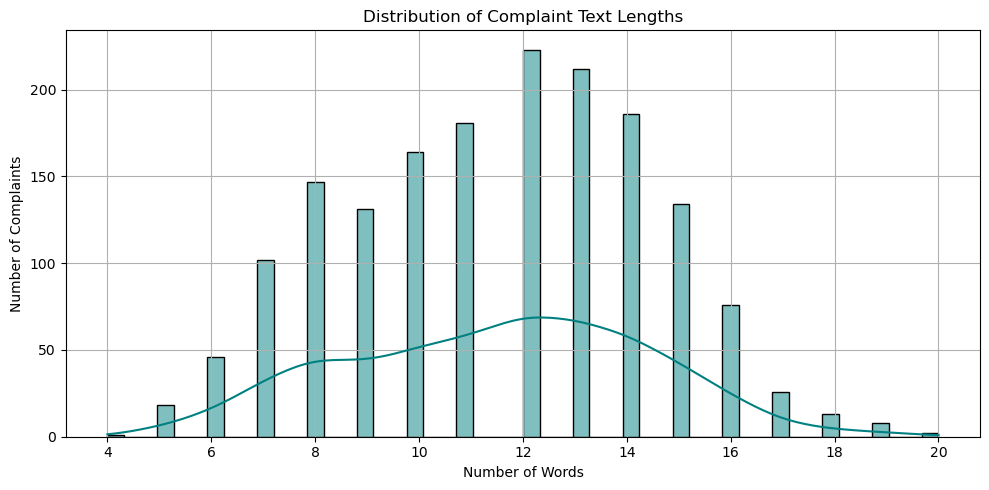

In [209]:
# histogram of complaint lengths
plt.figure(figsize=(10, 5))
sns.histplot(length_of_complaints, bins=50, kde=True, color='teal')
plt.title("Distribution of Complaint Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Complaints")
plt.grid(True)
plt.tight_layout()
plt.show()

<h3>text cleaning</h3>

In [31]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ziyaurrahamanshaik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ziyaurrahamanshaik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ziyaurrahamanshaik/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [211]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [213]:
len(stop_words)

198

In [215]:
def clean_text(text):
    # convert  into Lowercase
    text = text.lower()
     # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = text.split()
    # Removing stopwords and lemmatize
    cleaned_words = [
        lemmatizer.lemmatize(word)
        for word in words if word not in stop_words
    ]
    
    return ' '.join(cleaned_words)

In [217]:
df['Cleaned Text'] = df['Complaint Text'].apply(clean_text)

In [219]:
df.head()

,Unnamed: 0,Complaint Text,Category,Cleaned Text
0,0,Double payment processed for one membership on...,Payment Issue,double payment processed one membership codeca...
1,1,Double payment processed for one enrollment on...,Payment Issue,double payment processed one enrollment codeca...
2,2,Double payment processed for one course access...,Payment Issue,double payment processed one course access cod...
3,3,Double payment processed for one enrollment on...,Payment Issue,double payment processed one enrollment codeca...
4,4,Double payment processed for one membership on...,Payment Issue,double payment processed one membership codeca...


<h3>Text Vectorization</h3>

In [221]:
# # Loading GloVe
# embedding_index = {}
# with open('glove.6B.100d.txt', encoding='utf8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = vector
# print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

<h4>Saving embedding_index to a file</h4>

In [50]:
# Saving embedding_index to a file
# with open('glove_embedding_index.pkl', 'wb') as file:
#     pickle.dump(embedding_index, file)

# print("Embedding index saved successfully!")

Embedding index saved successfully!


In [224]:
# Load embedding_index from the file( to reduce time)
with open('glove_embedding_index.pkl', 'rb') as file:
    embedding_index = pickle.load(file)

print(f"Loaded {len(embedding_index)} word vectors from saved file.")

Loaded 400000 word vectors from saved file.


In [226]:
embedding_index["refund"]

array([ 0.27442  , -0.20869  ,  0.48401  , -0.52658  , -0.28813  ,
        0.2722   , -0.20021  ,  0.82182  ,  0.38269  ,  0.46013  ,
        0.23799  ,  0.96327  , -0.39575  , -0.055522 ,  0.28342  ,
       -0.75253  , -0.024518 ,  0.57289  ,  0.47708  ,  0.35955  ,
       -0.092931 ,  0.44223  , -0.57936  ,  0.11896  , -0.43158  ,
       -0.24031  , -0.091779 , -0.2491   , -0.060945 , -1.4849   ,
        0.58076  ,  0.80768  , -0.23065  , -0.0089164, -0.089394 ,
        0.18525  ,  0.12685  , -0.3145   , -0.1884   , -0.90968  ,
        0.60932  , -0.45767  , -0.071519 , -0.44782  , -0.089939 ,
       -0.52734  , -0.27929  , -0.80172  ,  0.48911  , -0.44459  ,
        0.903    ,  0.18044  ,  0.37231  , -0.42455  , -0.36753  ,
        0.24048  ,  0.61467  , -0.72114  ,  1.9183   , -0.28063  ,
        0.54857  , -0.40469  , -0.4479   ,  0.39296  ,  0.68427  ,
       -0.34506  , -0.36053  ,  0.015283 ,  0.17624  , -0.82384  ,
       -0.49856  ,  0.068219 , -0.16911  ,  0.038137 ,  0.1974

In [228]:

# Tokenize
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned Text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Convert text to padded sequences
sequences = tokenizer.texts_to_sequences(df['Cleaned Text'])
padded_sequences = pad_sequences(sequences, maxlen=30, padding='post')

In [230]:
len(word_index)

1470

In [232]:
sequences[:5]

[[169, 7, 37, 57, 266, 2],
 [169, 7, 37, 57, 267, 2],
 [169, 7, 37, 57, 3, 11, 2],
 [169, 7, 37, 57, 267, 2],
 [169, 7, 37, 57, 266, 2]]

In [234]:
padded_sequences[3]

array([169,   7,  37,  57, 267,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [236]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [238]:
len(embedding_matrix)

1471

In [242]:
embedding_matrix[5] # embedding_matrix maps a word index to its corresponding vector

array([-0.56888998,  1.07410002, -0.47046   , -0.0033372 ,  0.38510001,
       -0.14174999, -0.57630002, -0.30484   , -0.095918  ,  0.17786001,
       -0.24177   , -0.49157   , -0.11069   , -0.50344998,  0.091845  ,
       -0.40237999,  0.044992  , -0.44402999, -0.40237999,  0.56918001,
       -0.11842   , -0.29087001,  0.40975001, -0.11389   , -0.29725   ,
       -0.086441  ,  0.014207  , -0.26745999,  0.59259999,  0.066809  ,
        0.37691   ,  0.71682   , -0.028315  ,  0.53827   ,  0.29448   ,
        0.45475999,  0.56120002,  0.26344001, -0.27476999,  0.2525    ,
       -0.64091998, -0.3026    ,  0.86114001, -0.091432  ,  0.08479   ,
       -0.73649001,  0.118     , -0.26196   , -0.30272001, -0.81630999,
       -0.31151   ,  0.59153998,  0.12937   ,  1.13300002,  0.26651001,
       -2.31439996,  0.79084003, -1.25989997,  2.03740001,  0.25549999,
        0.058432  , -0.43257001,  0.054661  ,  0.62744999,  0.58951998,
        0.38389999, -0.34004   ,  0.39991999,  0.41631001, -0.02

In [244]:
embedding_matrix[5]==embedding_index["support"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

<h3>baseline model</h3>

In [246]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Category'])
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [248]:

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=30,
              trainable=False),  # Freeze GloVe weights
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │       147,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,100 (574.61 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 147,100 (574.61 KB)

In [250]:
# spliting the data
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences,     
    labels,               
    test_size=0.2,
    stratify=labels,      
    random_state=42
)

history = model.fit(X_train, y_train,
                validation_data=(X_val,y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1603 - loss: 2.1877 - val_accuracy: 0.3144 - val_loss: 2.1344
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.2848 - loss: 2.1147 - val_accuracy: 0.4042 - val_loss: 2.0353
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.3689 - loss: 2.0080 - val_accuracy: 0.5060 - val_loss: 1.9038
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.4438 - loss: 1.8948 - val_accuracy: 0.5928 - val_loss: 1.7567
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.4830 - loss: 1.7475 - val_accuracy: 0.6257 - val_loss: 1.6170
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.5408 - loss: 1.6053 - val_accuracy: 0.6916 - val_loss: 1.4895
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5881 - loss: 1.4875 - val_accuracy: 0.6976 - val_loss: 1.3724
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.5897 - loss: 1.4048 - val_accuracy: 0.7216

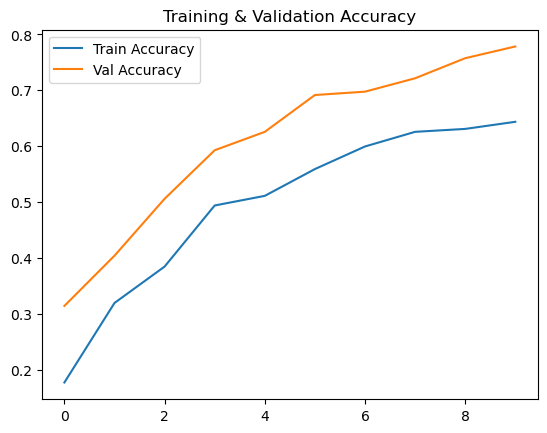

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                               precision    recall  f1-score   support

            Certificate Issue       0.92      0.97      0.94        34
        Content Quality Issue       0.88      0.66      0.75        32
          Course Access Issue       0.72      0.62      0.67        34
       Customer Support Issue       0.76      0.93      0.84        44
             Instructor Issue       0.93      0.78      0.85        32
Misleading Course Description       0.81      0.66      0.72        32
                Payment Issue       0.74      0.69      0.72        42
                 Refund Issue       0.75      0.86      0.80        42
             Technical Glitch       0.65      0.79      0.71        42

                     accuracy                           0.78       334
                    macro avg       0.79      0.77      0.78       334
                 weighted avg       0.79      0.78      0.78       334



In [252]:


# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()

# Classification report
y_pred = model.predict(X_val).argmax(axis=1)
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

In [254]:
unique_classes = np.unique(y_val)

print("Accuracy per class:\n")
for class_id in unique_classes:
    class_name = class_names[class_id]
    class_mask = (y_val == class_id)
    
    correct = np.sum(y_val[class_mask] == y_pred[class_mask])
    total = np.sum(class_mask)
    acc = correct / total

    print(f"{class_name:20s} → Accuracy: {acc:.4f} ({correct}/{total})")

Accuracy per class:

Certificate Issue    → Accuracy: 0.9706 (33/34)
Content Quality Issue → Accuracy: 0.6562 (21/32)
Course Access Issue  → Accuracy: 0.6176 (21/34)
Customer Support Issue → Accuracy: 0.9318 (41/44)
Instructor Issue     → Accuracy: 0.7812 (25/32)
Misleading Course Description → Accuracy: 0.6562 (21/32)
Payment Issue        → Accuracy: 0.6905 (29/42)
Refund Issue         → Accuracy: 0.8571 (36/42)
Technical Glitch     → Accuracy: 0.7857 (33/42)


In [256]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7784


In [258]:
print("Precision:", precision_score(y_val, y_pred, average='weighted'))
print("Recall:", recall_score(y_val, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))

Precision: 0.7861610389941152
Recall: 0.7784431137724551
F1 Score: 0.7763823940188596


In [185]:
# Random Complaints testing

In [260]:
test_complaints = [
    "I can't access my course after logging in, it keeps showing a blank screen.",
    "I requested a refund last week and still haven't received my money back.",
    "The video keeps buffering every few seconds — it’s impossible to follow the lesson.",
    "The instructor just reads the slides, there's no explanation or interaction.",
    "The course description promised a project but there's none included.",
    "I finished the course but didn’t receive any certificate of completion.",
    "Customer support hasn't replied to my emails in over 10 days!",
    "There are tons of spelling mistakes and grammar issues in the content.",
]

In [262]:
for complaint in test_complaints:
    cleaned = clean_text(complaint)  
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=X_train.shape[1], padding='post')
    y_pred = model.predict(padded)
    pred_class = np.argmax(y_pred, axis=1)
    predicted_label = label_encoder.inverse_transform(pred_class)[0]
    print(f"Complaint: {complaint}")
    print(f"Predicted Category: {predicted_label}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Complaint: I can't access my course after logging in, it keeps showing a blank screen.
Predicted Category: Technical Glitch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Complaint: I requested a refund last week and still haven't received my money back.
Predicted Category: Refund Issue

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Complaint: The video keeps buffering every few seconds — it’s impossible to follow the lesson.
Predicted Category: Technical Glitch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Complaint: The instructor just reads the slides, there's no explanation or interaction.
Predicted Category: Instructor Issue

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Complaint: The course description promised a project but there's none included.
Predicted Category: Misleading Course Description

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Complaint: I finished the course but didn’t receive any certificate of completion.
Predicted Category: Certificate Issue

1/1 ━━━━━━━━━━━━━━━

<h3>using LSTM</h3>

In [322]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              # input_length=20,
              trainable=False),  # GloVe embeddings (frozen)

    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [324]:
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [326]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2103 - loss: 2.1273 - val_accuracy: 0.5120 - val_loss: 1.7022
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4755 - loss: 1.5496 - val_accuracy: 0.6826 - val_loss: 0.9858
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6974 - loss: 0.9544 - val_accuracy: 0.7934 - val_loss: 0.6677
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7837 - loss: 0.6551 - val_accuracy: 0.8383 - val_loss: 0.5111
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8161 - loss: 0.5435 - val_accuracy: 0.8443 - val_loss: 0.4138
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8562 - loss: 0.3940 - val_accuracy: 0.8533 - val_loss: 0.3986
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8791 - loss: 0.3457 - val_accuracy: 0.8772 - val_loss: 0.3673
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9147 - loss: 0.2617 - val_accuracy: 0.8623 - val_los

In [328]:
# Evaluate model
val_loss, val_accuracy = model_lstm.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8623


In [330]:
# Predict class probabilities
y_pred_probs = model_lstm.predict(X_val)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [332]:
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))



Classification Report:

                               precision    recall  f1-score   support

            Certificate Issue       0.97      1.00      0.99        34
        Content Quality Issue       0.88      0.66      0.75        32
          Course Access Issue       0.65      0.76      0.70        34
       Customer Support Issue       0.84      0.93      0.88        44
             Instructor Issue       0.97      0.94      0.95        32
Misleading Course Description       0.76      0.81      0.79        32
                Payment Issue       0.93      0.95      0.94        42
                 Refund Issue       0.93      0.90      0.92        42
             Technical Glitch       0.86      0.76      0.81        42

                     accuracy                           0.86       334
                    macro avg       0.87      0.86      0.86       334
                 weighted avg       0.87      0.86      0.86       334



In [334]:
print("Accuracy : ",accuracy_score(y_val, y_pred))

Accuracy :  0.8622754491017964


<h3>lstm model 2</h3>

In [336]:
model_lstm2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),

    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),

    Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [338]:
model_lstm2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [340]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]



In [160]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1336, 30)
y_train shape: (1336,)


In [342]:

history = model_lstm2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1857 - loss: 2.5954 - val_accuracy: 0.5269 - val_loss: 2.1163
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4133 - loss: 1.7768 - val_accuracy: 0.6407 - val_loss: 1.9099
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5329 - loss: 1.3876 - val_accuracy: 0.7246 - val_loss: 1.6794
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6116 - loss: 1.1905 - val_accuracy: 0.7635 - val_loss: 1.3816
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6608 - loss: 1.0513 - val_accuracy: 0.8084 - val_loss: 1.1584
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7135 - loss: 0.9549 - val_accuracy: 0.8114 - val_loss: 0.9604
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7624 - loss: 0.8158 - val_accuracy: 0.8234 - val_loss: 0.7985
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7695 - loss: 0.7864 - val_accuracy: 0.8293 - val

In [344]:
loss, accuracy = model_lstm2.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8632 - loss: 0.3793 
Test Loss: 0.4024
Test Accuracy: 0.8533


In [401]:
# Predicting class probabilities
y_pred_probs = model_lstm2.predict(X_val)

# Convert to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)


y_true = y_val  

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
 [[34  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0 10  0  0  2]
 [ 0  0 20  0  0  9  1  0  4]
 [ 0  1  0 42  0  0  0  1  0]
 [ 0  0  0  0 32  0  0  0  0]
 [ 0  2  2  0  0 28  0  0  0]
 [ 0  0  3  1  0  1 36  1  0]
 [ 0  0  0  3  0  1  0 37  1]
 [ 0  1  3  1  0  0  1  0 36]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.83      0.62      0.71        32
           2       0.71      0.59      0.65        34
           3       0.89      0.95      0.92        44
           4       1.00      1.00      1.00        32
           5       0.57      0.88      0.69        32
           6       0.95      0.86      0.90        42
           7       0.95      0.88      0.91        42
           8       0.84      0.86      0.85        42

    accuracy                           0.85       334
   macro avg       0.86      0.85      0.85      

In [403]:
accuracy_score(y_true, y_pred)

0.8532934131736527

<h3>model 3 lstm</h3>

In [407]:
model3 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    
    Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [409]:
import tensorflow as tf
model3.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [411]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)



In [413]:
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1292 - loss: 2.6626 - val_accuracy: 0.4102 - val_loss: 2.2093
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2986 - loss: 2.0046 - val_accuracy: 0.5359 - val_loss: 2.1086
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4547 - loss: 1.6194 - val_accuracy: 0.6467 - val_loss: 1.9880
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5351 - loss: 1.3513 - val_accuracy: 0.7515 - val_loss: 1.8397
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6165 - loss: 1.1853 - val_accuracy: 0.7904 - val_loss: 1.6930
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6904 - loss: 0.9849 - val_accuracy: 0.8114 - val_loss: 1.5270
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7331 - loss: 0.9140 - val_accuracy: 0.8234 - val_loss: 1.3536
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7544 - loss: 0.8464 - val_accuracy: 0.8533 - v

Text(0.5, 1.0, 'Training vs Validation Accuracy')

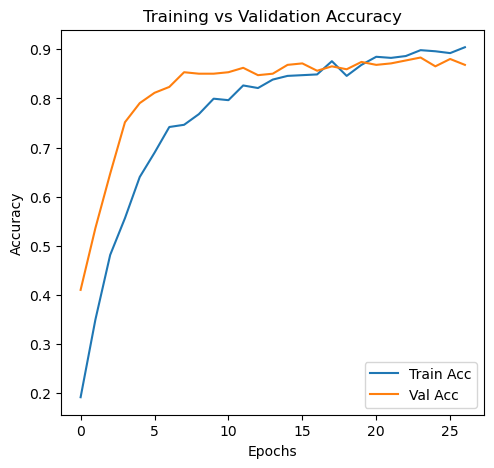

In [421]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

In [423]:

y_pred_probs = model3.predict(X_val)

# Get predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report 
print(classification_report(y_val, y_pred, target_names=class_names))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
                               precision    recall  f1-score   support

            Certificate Issue       0.97      1.00      0.99        34
        Content Quality Issue       0.88      0.69      0.77        32
          Course Access Issue       0.73      0.79      0.76        34
       Customer Support Issue       0.91      0.93      0.92        44
             Instructor Issue       1.00      0.97      0.98        32
Misleading Course Description       0.74      0.91      0.82        32
                Payment Issue       0.92      0.86      0.89        42
                 Refund Issue       0.95      0.93      0.94        42
             Technical Glitch       0.86      0.86      0.86        42

                     accuracy                           0.88       334
                    macro avg       0.89      0.88      0.88       334
                 weighted avg       0.89      0.88      0.88       334



In [425]:
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc*100)

Accuracy: 88.32335329341318


In [427]:
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1-score (macro):", f1)

Precision (macro): 0.885255383141562
Recall (macro): 0.8812547746371275
F1-score (macro): 0.8806853267311844


In [432]:
model3.save("complaint_classifier_model.h5")

In [435]:
# saving tokenzizer

In [437]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [441]:
# saving labelencoder

In [443]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)